In [1]:
import pandas as pd

# Load the dataset
df = pd.read_excel("HousePricePrediction.xlsx")

# Display first 5 rows
df.head()


Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0

In [3]:
# Check the number of rows and columns
print("Dataset Shape:", df.shape)

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Dataset Shape: (2919, 13)
Missing Values:
 Id                 0
MSSubClass         0
MSZoning           4
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        1
BsmtFinSF2         1
TotalBsmtSF        1
SalePrice       1459
dtype: int64


In [5]:
# Fill categorical missing values with mode
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])

# Fill numerical missing values with median
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].median())
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].median())

# Verify missing values again
print("Missing Values After Filling:\n", df.isnull().sum())

Missing Values After Filling:
 Id                 0
MSSubClass         0
MSZoning           0
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        0
BsmtFinSF2         0
TotalBsmtSF        0
SalePrice       1459
dtype: int64


In [6]:
df.drop(columns=['Id'], inplace=True)

In [7]:
# Training data (SalePrice available)
train_df = df[df['SalePrice'].notnull()]

# Testing data (SalePrice missing)
test_df = df[df['SalePrice'].isnull()].drop(columns=['SalePrice'])  # Remove target from test

In [8]:
# Convert categorical columns using one-hot encoding
categorical_cols = ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

In [9]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns
num_cols = ['MSSubClass', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF2', 'TotalBsmtSF']

# Initialize scaler
scaler = StandardScaler()

# Fit & transform training data
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

# Transform test data (using same scaler)
test_df[num_cols] = scaler.transform(test_df[num_cols])

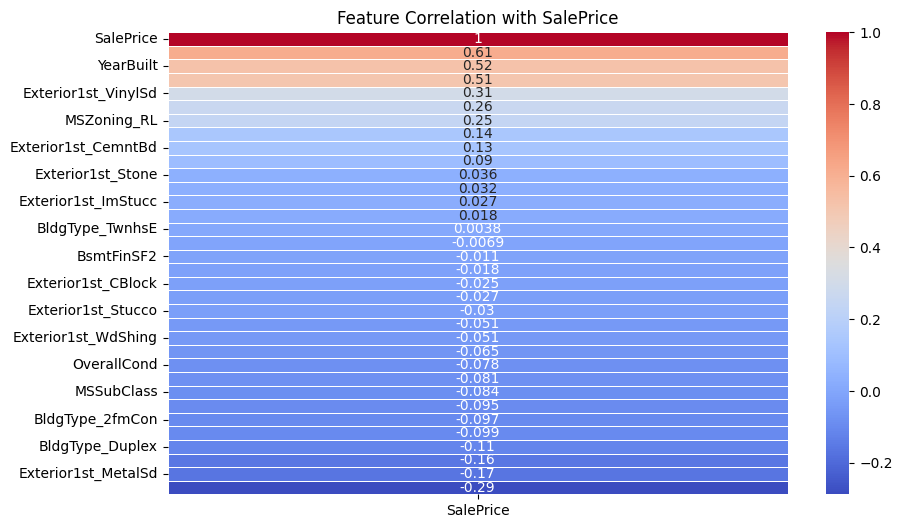

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with SalePrice")
plt.show()

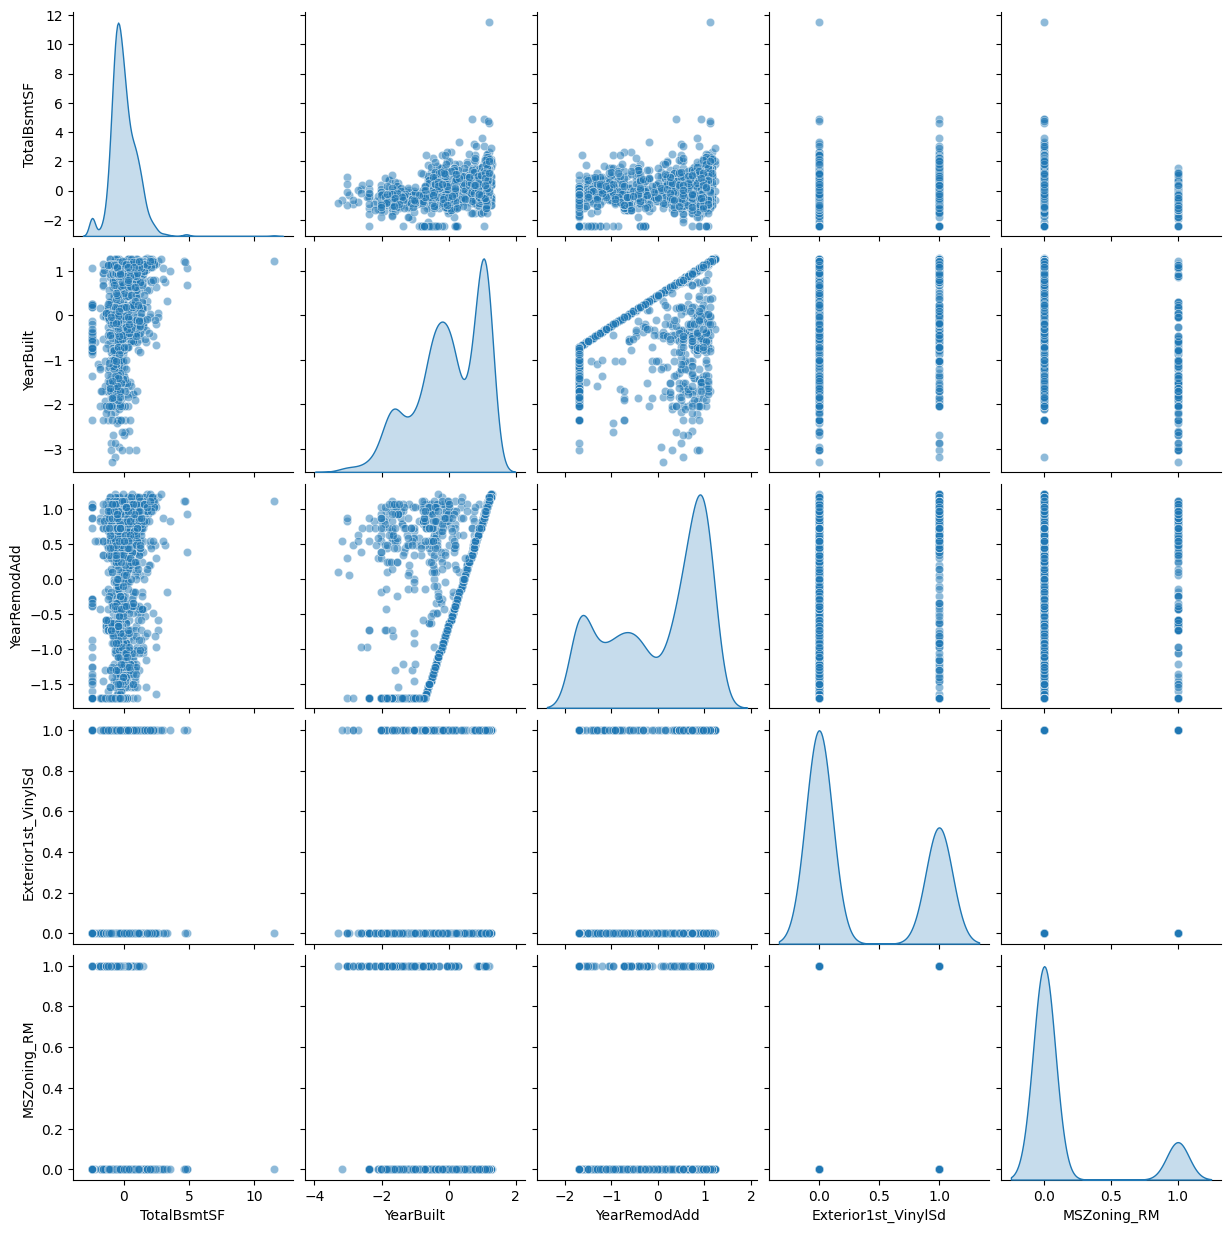

In [11]:
# Visualize scatter plots of top correlated features
top_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)[1:6].index  # Top 5 features
sns.pairplot(train_df, vars=top_features, diag_kind='kde', plot_kws={'alpha':0.5})
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Define target variable and features
X = train_df.drop(columns=['SalePrice'])  # Features
y = train_df['SalePrice']  # Target variable

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (1168, 33)
Testing Data Shape: (292, 33)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} model trained successfully!")

Linear Regression model trained successfully!
Decision Tree model trained successfully!
Random Forest model trained successfully!
XGBoost model trained successfully!


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2

# Evaluate all models
for name, model in models.items():
    rmse, mae, r2 = evaluate_model(model, X_test, y_test)
    print(f"Model: {name} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R² Score: {r2:.2f}")

Model: Linear Regression | RMSE: 54022.75 | MAE: 34122.85 | R² Score: 0.62
Model: Decision Tree | RMSE: 46593.01 | MAE: 31360.91 | R² Score: 0.72
Model: Random Forest | RMSE: 37538.94 | MAE: 23100.15 | R² Score: 0.82
Model: XGBoost | RMSE: 36821.97 | MAE: 23162.61 | R² Score: 0.82


In [16]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Initialize GridSearch
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Best Model
best_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [18]:
import pickle

# Save model using pickle
with open("house_price_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Model saved successfully!")

Model saved successfully!


In [21]:
import pickle

# Load the model
with open("house_price_model.pkl", "rb") as file:
    model = pickle.load(file)

# Print the expected feature names
print(model.feature_names_in_)


['MSSubClass' 'LotArea' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'BsmtFinSF2' 'TotalBsmtSF' 'MSZoning_FV' 'MSZoning_RH' 'MSZoning_RL'
 'MSZoning_RM' 'LotConfig_CulDSac' 'LotConfig_FR2' 'LotConfig_FR3'
 'LotConfig_Inside' 'BldgType_2fmCon' 'BldgType_Duplex' 'BldgType_Twnhs'
 'BldgType_TwnhsE' 'Exterior1st_AsphShn' 'Exterior1st_BrkComm'
 'Exterior1st_BrkFace' 'Exterior1st_CBlock' 'Exterior1st_CemntBd'
 'Exterior1st_HdBoard' 'Exterior1st_ImStucc' 'Exterior1st_MetalSd'
 'Exterior1st_Plywood' 'Exterior1st_Stone' 'Exterior1st_Stucco'
 'Exterior1st_VinylSd' 'Exterior1st_Wd Sdng' 'Exterior1st_WdShing']
